## Example usage notebook
Objects and functions in this notebook are listed with all paramaters to ilustrate their capabillities. Most of the paramaters have default values in the implementation

## Imports

In [1]:
import os
import json
from typing import Literal
import pandas as pd

from lightv import config
from data_preparation.prepare_target import (
    BuildBinaryTarget,
    BuildMulticlassTarget,
    BuildRegressionTarget,
)
from data_preparation.preprocess_data_general import GeneralPrepareData
from lightv.train_test_split.train_test_split import TrainTestSplit
from lightv.training.trainer import Trainer
from lightv.training.optuna_optimizer import LGBOptunaOptimizer
from lightv.training.ray_optimizer import LGBRayTuneOptimizer

import dill
import numpy as np
from lightv.explain.explainer import ShapExplainer
from lightv.general_utils import dill_dump
from lightv.general_utils import dill_load

from ray.tune.suggest.bayesopt import BayesOptSearch
from ray.tune.suggest.optuna import OptunaSearch

## Train a testing model 

In [2]:
# 1. get the data
from pathlib import Path

with open(Path("../data") / config.TOY_DATASET_COLUMNS_DEFINITION_FNAME, "rb") as f:
    columns_definition = json.load(f)
raw_data = pd.read_parquet(Path("../data") / config.TOY_DATASET_FNAME)

In [3]:
columns_definition

{'id_cols': ['user_id'],
 'target': 'target',
 'target_ltv': 'target_ltv',
 'categorical': ['city_first',
  'continent_first',
  'country_first',
  'state_first',
  'mobile_model_name_first',
  'campaign_first',
  'adset_first',
  'af_status_first'],
 'target_ltv_cls': 'target_ltv_cls'}

In [4]:
raw_data.head()

,user_id,count_errorfound_time_stamp,count_applaunched_time_stamp,count_applaunched_install_time,count_depositclicked_time_stamp,count_depositdialogviewed_time_stamp,count_depositinitiated_time_stamp,count_depositoffersshowed_time_stamp,count_depositpackclicked_time_stamp,count_depositvaluechanged_time_stamp,...,avg_urostercancelled_rake_amount,min_urostercancelled_rake_amount,max_urostercancelled_rake_amount,avg_memoryinfoongamelaunch_native_memory_now_in_mb,min_memoryinfoongamelaunch_native_memory_now_in_mb,max_memoryinfoongamelaunch_native_memory_now_in_mb,count_topupdialogviewed_app_version,count_g_bench_low_fps_time_stamp,target_ltv,target
0,005vT7y75hVO1fZMsSR6W1h9l583,56,11,0,5,2,3,13,3,19,...,<NA>,<NA>,<NA>,41.804474,41.804474,41.804474,16,9,1.257455,1.257455
1,00EbaSg3fTO7Sev8pYoWAJq9Hc43,50,5,0,1,<NA>,1,7,<NA>,7,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,5,<NA>,6.185779,6.185779
2,00FQoVOsL7Qke16BNqqsHoyt7Ul1,26,1,0,1,<NA>,1,4,<NA>,1,...,<NA>,<NA>,<NA>,312.256586,51.415237,829.290985,1,<NA>,5.475,5.475
3,00HAhMxOURSSwmEVhSfQDKwRxKz1,250,61,0,2,3,<NA>,1,<NA>,7,...,<NA>,<NA>,<NA>,59.93631,59.93631,59.93631,22,11,0.30936,0.30936
4,00JEpTvvm4RXvv8wkihCTVAngAH3,12,1,0,<NA>,<NA>,<NA>,1,<NA>,<NA>,...,<NA>,<NA>,<NA>,64.058823,64.058823,64.058823,2,<NA>,0.087146,0.087146


In [5]:
objective: Literal["binary", "multiclass", "regression", "quantile_regression"] = (
    "quantile_regression"
)
if objective == "binary":
    prepare_target = BuildBinaryTarget(
        target_col=columns_definition["target_ltv"],
        binary_strategy="threshold",
        binary_threshold=500.0,
    )
    n_class = 2
    data = prepare_target.transform(df=raw_data)
if objective == "multiclass":
    prepare_target = BuildMulticlassTarget(
        target_col=columns_definition["target_ltv"],
        multiclass_bins=[0, 500, 1000, 2000, np.inf],
    )
    n_class = 4
    data = prepare_target.transform(df=raw_data)
if objective in ["regression", "quantile_regression"]:
    prepare_target = BuildRegressionTarget(
        target_col=columns_definition["target_ltv"],
        regression_early_target_col=None,
        regression_strategy=None,
        regression_target_col_thr=None,
        regression_early_target_thr_range=None,
    )
    n_class = None
    data = prepare_target.transform(df=raw_data)

prepare_data = GeneralPrepareData(
    target_col=prepare_target.final_target_col,
    id_cols=columns_definition["id_cols"],
    init_cat_cols=[],
    cat_threshold=200,
    init_cont_cols=[],
    verbose=False,
)
prepare_data.fit(df=data)

In [6]:
data[prepare_target.final_target_col]

0        1.257455
1        6.185779
2           5.475
3         0.30936
4        0.087146
           ...   
45530    0.213628
45531         0.0
45532        0.18
45533      4.2375
45534    0.048434
Name: target_ltv_regression, Length: 45535, dtype: Float64

In [7]:
splitter = TrainTestSplit(
    target_col=prepare_data.target_col,
    temporal_col=None,
    temporal=False,
    target_type=objective,
    test_size=0.2,
    valid_size=0.5,
    random_state=0,
    save_dir=None,
)

# optimizer = LGBOptunaOptimizer(
#         objective=objective,
#         quantiles=[0.25, 0.5, 0.75],
#         n_class=n_class,
#         loss=None,
#     )

optimizer = LGBRayTuneOptimizer(
    opt_metric="quantile",
    objective=objective,
    search_alg=BayesOptSearch(),
    loss=None,
    n_class=n_class,
    num_samples=2,
    search_params=None,
    scheduler=None,
)

trainer = Trainer(
    cat_cols=prepare_data.cat_cols,
    target_col=prepare_data.target_col,
    id_cols=prepare_data.id_cols,
    objective=objective,
    loss=None,
    n_class=n_class,
    optimizer=optimizer,
    preprocessors=[prepare_data],
)

metrics_dict = trainer.fit(
    df=data,
    splitter=splitter,
)
trainer.train(df_train=data)

2022-09-08 18:24:36,642	WARNING function_runner.py:603 -- Function checkpointing is disabled. This may result in unexpected behavior when using checkpointing features or certain schedulers. To enable, set the train function arguments to be `func(config, checkpoint_dir=None)`.
2022-09-08 18:24:36,647	WARNING bayesopt.py:408 -- BayesOpt does not support specific sampling methods. The Uniform sampler will be dropped.
2022-09-08 18:24:36,647	WARNING bayesopt.py:408 -- BayesOpt does not support specific sampling methods. The Uniform sampler will be dropped.
2022-09-08 18:24:36,648	WARNING bayesopt.py:408 -- BayesOpt does not support specific sampling methods. The Uniform sampler will be dropped.
2022-09-08 18:24:36,648	WARNING bayesopt.py:408 -- BayesOpt does not support specific sampling methods. The Uniform sampler will be dropped.
2022-09-08 18:24:36,648	WARNING bayesopt.py:408 -- BayesOpt does not support specific sampling methods. The Uniform sampler will be dropped.
2022-09-08 18:24:3

Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[916]	val's quantile: 7.72227
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[142]	val's quantile: 12.9393
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[21]	val's quantile: 16.5444


In [11]:
# save/load trainer
dill_dump("temp.dill", trainer)
trainer = dill_load("temp.dill")

In [11]:
trainer.model

{'0.25': <lightgbm.basic.Booster at 0x7f56f18863d0>,
 '0.5': <lightgbm.basic.Booster at 0x7f5741000e80>,
 '0.75': <lightgbm.basic.Booster at 0x7f5741000fa0>}

In [8]:
metrics_dict

{'rmse': 509.9134897739657,
 'mae': 21.686365327106138,
 'r2': 0.4425859946485303,
 'mpl_0.25': 6.676980358164174,
 'mpl_0.5': 10.843182663553069,
 'mpl_0.75': 13.633560813657759}

## Explain the predictions

In [10]:
data[columns_definition["target_ltv"]]

0        1.257455
1        6.185779
2           5.475
3         0.30936
4        0.087146
           ...   
45530    0.213628
45531         0.0
45532        0.18
45533      4.2375
45534    0.048434
Name: target_ltv, Length: 45535, dtype: Float64

In [11]:
# from lightv.general_utils import save_to_dir
# data_to_predict = prepare_data.transform(data).drop(columns=[prepare_data.target_col])
# data_predict = trainer.predict(data_to_predict)
# data_predict_cls = trainer.predict_cls(data_to_predict)
# data_predict_proba = trainer.predict_proba(data_to_predict)

# save_to_dir(objects=[(data_predict, "data_predict_multiclass.parquet"), (data_predict_cls, "data_predict_multiclass_cls.parquet"), (data_predict_proba, "data_predict_multiclass_proba.parquet")], save_dir="results")
save_to_dir(
    objects=[
        (data[columns_definition["target_ltv"]], "data_ground_truth_regression.parquet")
    ],
    save_dir="results",
)

In [6]:
# save/load trainer
# dill_dump("temp.dill", trainer)
# trainer = dill_load("temp.dill")

In [8]:
data_to_explain = prepare_data.transform(data.loc[:0]).drop(
    columns=prepare_data.id_cols + [prepare_data.target_col]
)

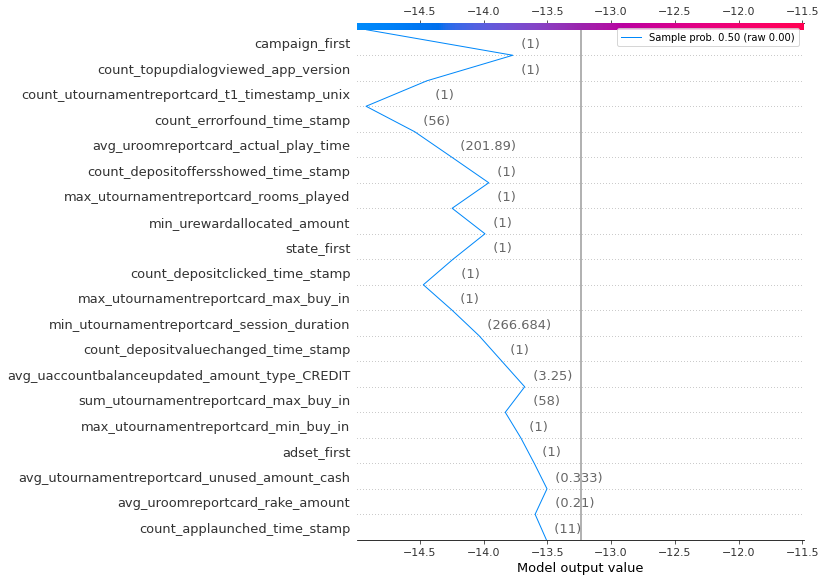

In [9]:
shap_explainer = ShapExplainer()
shap_explainer.fit(
    model=trainer.model,
    objective=objective,
    explainer_type="default",
)
shap_explainer.explain_decision_plot(
    X_tab_explain=data_to_explain.values[0],
    feature_names=data_to_explain.columns.to_list(),
)